In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-factitial-dermatitis-1.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/v-eczema-areola-13.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-eczema-subacute-66.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-eczema-hand-86.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-keratolysis-exfoliativa-17.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-lichen-simplex-chronicus-136.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-eczema-subacute-60.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-fissure-11.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-Dyshidrosis-36.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Eczema 1677/t-Dyshidrosis-55.jpg
/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES/1. Ecz

In [2]:
# Check if GPU is available
print("Checking GPU availability...")
!nvidia-smi

Checking GPU availability...
Mon May 12 22:08:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

# Keras imports
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import EfficientNetB7
from keras.callbacks import ReduceLROnPlateau
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Updated ImageDataGenerator import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array

# Sklearn imports
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# General imports
import random
import keras

import shutil

2025-05-12 22:08:18.399618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747087698.886850      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747087699.025213      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Define paths
data_path = '/kaggle/input/skin-diseases-image-dataset/IMG_CLASSES'
output_path = '/kaggle/working/Skin-disease-images'


# Remove the existing dataset from the working directory if it exists
if os.path.exists(output_path):
    shutil.rmtree(output_path)

# Copy the dataset to a writable directory
if not os.path.exists(output_path):
    shutil.copytree(data_path, output_path)

Class counts: {'8. Seborrheic Keratoses and other Benign Tumors - 1.8k': 1847, '3. Atopic Dermatitis - 1.25k': 1257, '10. Warts Molluscum and other Viral Infections - 2103': 2103, '1. Eczema 1677': 1677, '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k': 1702, '5. Melanocytic Nevi (NV) - 7970': 7970, '4. Basal Cell Carcinoma (BCC) 3323': 3323, '2. Melanoma 15.75k': 3140, '7. Psoriasis pictures Lichen Planus and related diseases - 2k': 2055, '6. Benign Keratosis-like Lesions (BKL) 2624': 2079}


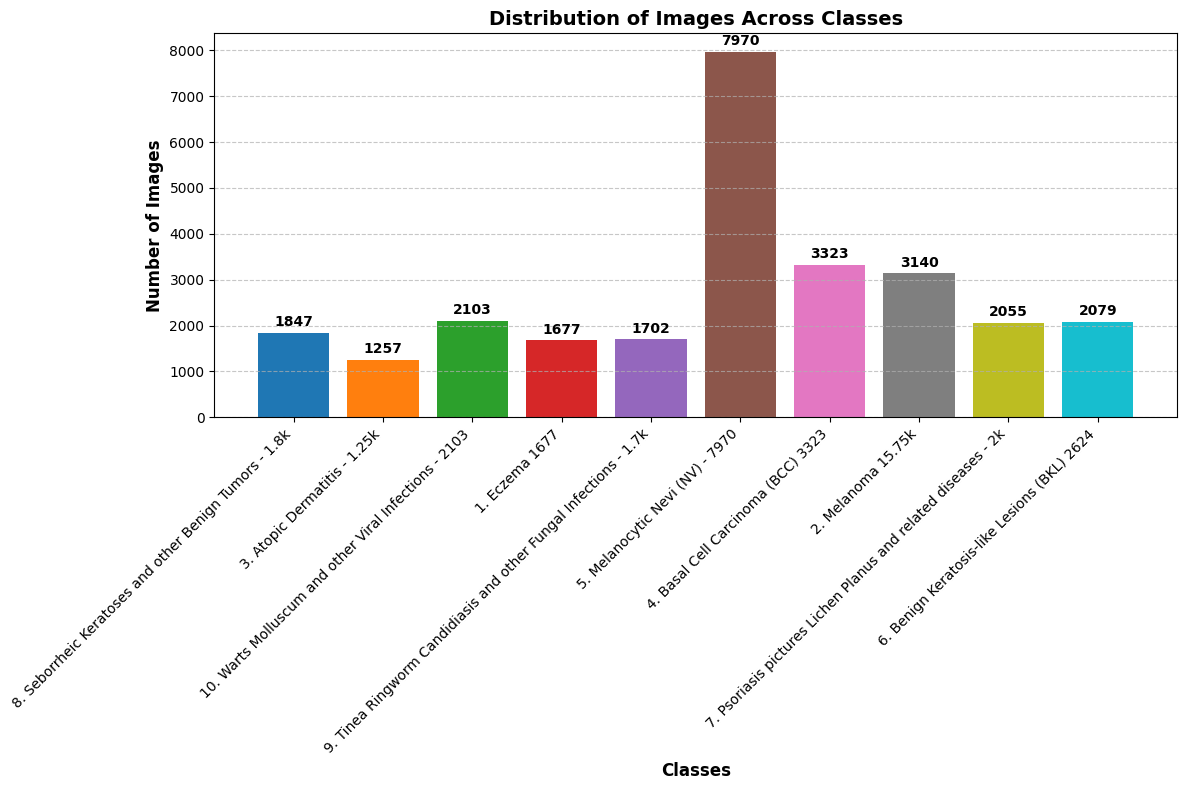

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Use the copied dataset
classes = os.listdir(output_path)
class_counts = [len(os.listdir(os.path.join(output_path, x))) for x in classes]
print("Class counts:", dict(zip(classes, class_counts)))

# Define a better color palette
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

# Visualize class counts with improvements
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(classes)), class_counts, color=colors)

# Improve axis labels and title
plt.xlabel('Classes', fontsize=12, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.title('Distribution of Images Across Classes', fontsize=14, fontweight='bold')

# Make class names readable
plt.xticks(range(len(classes)), classes, rotation=45, ha='right', fontsize=10)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (max(class_counts) * 0.01),  # Small offset above bar
        f'{height}',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

# Improve overall appearance
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
from PIL import Image
import numpy as np

# Oversampler function
def oversampler(class_name, class_count, target=7000, batch_size=32, target_size=(240, 240)):
    # Initialize the ImageDataGenerator with augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    curr_dir = os.path.join(output_path, class_name)
    save_dir = curr_dir

    # Load images from the current class folder
    images = os.listdir(curr_dir)
    images = [os.path.join(curr_dir, img) for img in images]

    cnt = class_count
    target = target
    
    # Loop over images in batches, apply augmentation, and save them
    while cnt < target:
        batch_images = []
        
        # Load and resize images to the target size before converting to NumPy array
        for img_path in random.sample(images, batch_size):
            img = Image.open(img_path)
            img = img.resize(target_size)  # Resize the image
            img = np.array(img)  # Convert the PIL image to a NumPy array
            batch_images.append(img)

        batch_images = np.array(batch_images)  # Convert the list of images to a NumPy array

        # Process and augment the batch of images
        for _ in datagen.flow(batch_images, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            cnt += batch_size
            if cnt >= target:
                break
        
        print(f"Processed {cnt}/{target} images for {class_name}")

# Undersampler function
def undersampler(class_name, class_count, target_count=7000):
    curr_dir = os.path.join(output_path, class_name)
    images = os.listdir(curr_dir)

    # Calculate the number of images to delete
    images_to_delete = random.sample(images, class_count - target_count)

    # Delete images in batches
    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        try:
            os.remove(img_path)
        except Exception as e:
            print(f"Error deleting {img_path}: {e}")

    print(f"Deleted {len(images_to_delete)} images for {class_name}")

In [7]:
# Oversample or undersample each class
for i, class_name in enumerate(classes):
    if class_counts[i] < 7000:
        oversampler(class_name, class_counts[i])
    else:
        undersampler(class_name, class_counts[i])

print("Oversampling and undersampling completed successfully.")

Processed 7031/7000 images for 8. Seborrheic Keratoses and other Benign Tumors - 1.8k
Processed 7017/7000 images for 3. Atopic Dermatitis - 1.25k
Processed 7031/7000 images for 10. Warts Molluscum and other Viral Infections - 2103
Processed 7021/7000 images for 1. Eczema 1677
Processed 7014/7000 images for 9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k
Deleted 970 images for 5. Melanocytic Nevi (NV) - 7970
Processed 7003/7000 images for 4. Basal Cell Carcinoma (BCC) 3323
Processed 7012/7000 images for 2. Melanoma 15.75k
Processed 7015/7000 images for 7. Psoriasis pictures Lichen Planus and related diseases - 2k
Processed 7007/7000 images for 6. Benign Keratosis-like Lesions (BKL) 2624
Oversampling and undersampling completed successfully.


Class counts: {'8. Seborrheic Keratoses and other Benign Tumors - 1.8k': 6976, '3. Atopic Dermatitis - 1.25k': 6974, '10. Warts Molluscum and other Viral Infections - 2103': 6990, '1. Eczema 1677': 6983, '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k': 6975, '5. Melanocytic Nevi (NV) - 7970': 7000, '4. Basal Cell Carcinoma (BCC) 3323': 6985, '2. Melanoma 15.75k': 6988, '7. Psoriasis pictures Lichen Planus and related diseases - 2k': 6980, '6. Benign Keratosis-like Lesions (BKL) 2624': 6974}


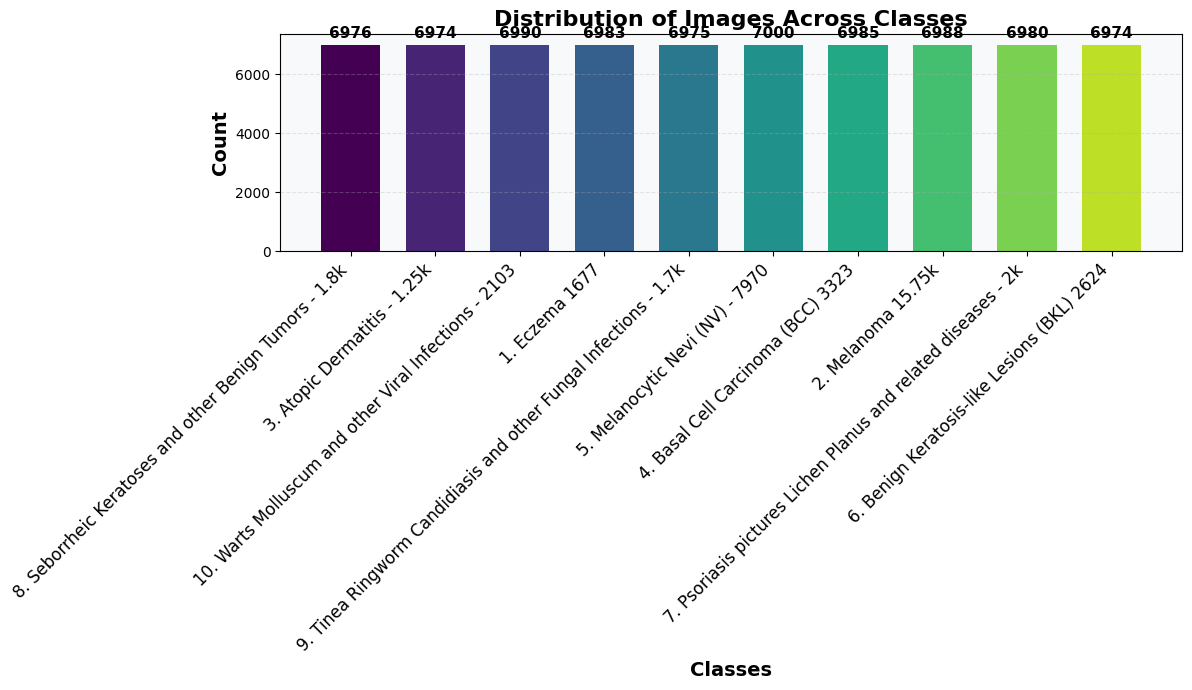

In [8]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Use the copied dataset
classes = os.listdir(output_path)
class_counts = [len(os.listdir(os.path.join(output_path, x))) for x in classes]
print("Class counts:", dict(zip(classes, class_counts)))

# Visualize class counts
plt.figure(figsize=(12, 10))  # Increased figure size for better readability

# Use a professional color palette
colors = plt.cm.viridis(np.linspace(0, 0.9, len(classes)))

# Create bars with improved spacing
bars = plt.bar(range(len(classes)), class_counts, color=colors, width=0.7)

# Set x-axis with rotated labels for better readability
plt.xticks(range(len(classes)), classes, rotation=45, ha='right', fontsize=12)

# Improve labels and title
plt.xlabel('Classes', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Images Across Classes', fontsize=16, fontweight='bold')

# Add count values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + (max(class_counts) * 0.02),  # Add small offset above the bar
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Adjust layout to prevent cut-off labels
plt.tight_layout()

# Add a subtle background color
plt.gca().set_facecolor('#f8f9fa')

plt.show()

In [9]:
import os
import random
import shutil

# Define paths for training, validation, and testing datasets
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'
test_path = '/kaggle/working/test'

# Create directories for each dataset split
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the split ratios for train, validation, and test datasets
train_ratio = 0.7  # 70% for training
val_ratio = 0.15   # 15% for validation
test_ratio = 0.15  # 15% for testing

# Loop over each class in the output dataset and split it
for class_folder in os.listdir(output_path):  # using the output_path where dataset resides
    class_path = os.path.join(output_path, class_folder)
    
    # Create class directories in train, val, and test folders
    train_class_path = os.path.join(train_path, class_folder)
    val_class_path = os.path.join(val_path, class_folder)
    test_class_path = os.path.join(test_path, class_folder)
    
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(val_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)
    
    # List and shuffle the images in the current class folder
    images = os.listdir(class_path)
    random.shuffle(images)
    num_images = len(images)
    
    # Split the images based on the defined ratios
    num_train = int(num_images * train_ratio)
    num_val = int(num_images * val_ratio)
    num_test = num_images - num_train - num_val
    
    # Allocate images to each split
    train_images = images[:num_train]
    val_images = images[num_train:num_train + num_val]
    test_images = images[num_train + num_val:]
    
    # Copy images to the appropriate directories
    for image in train_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(train_class_path, image))
    
    for image in val_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(val_class_path, image))
    
    for image in test_images:
        shutil.copy(os.path.join(class_path, image), os.path.join(test_class_path, image))

print("Dataset split completed successfully.")

Dataset split completed successfully.


In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define image size and batch size
img_size = (256, 256)
batch_size = 32

# Paths to train and validation datasets (as defined in the previous steps)
train_path = '/kaggle/working/train'
val_path = '/kaggle/working/val'

# Create the train dataset
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=123
)

# Get the class names from the training dataset
class_names = train_dataset.class_names

# Create the validation dataset
val_dataset = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42
)

# Display class names (optional)
print("Class Names:", class_names)

Found 48874 files belonging to 10 classes.


I0000 00:00:1747088575.742078      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747088575.742814      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 10471 files belonging to 10 classes.
Class Names: ['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']


In [11]:
import tensorflow as tf
# Preprocessing function
@tf.function
def preprocess_image(image, label):
    # Resize the image
    image = tf.image.resize(image, [256, 256])
    # Apply EfficientNet preprocessing
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# Apply the preprocessing pipeline to the datasets
train_dataset = train_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

In [12]:
from keras.applications.efficientnet import preprocess_input


# Feature extractor
base_model = keras.applications.EfficientNetB3(
    input_shape=(256, 256, 3), 
    include_top=False,             
    weights='imagenet',
    pooling='max'
) 

for layer in base_model.layers:
    layer.trainable = False

# Build model
inputs = base_model.input
x = BatchNormalization()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x) #output layer 
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
# Train the model
epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping, lr_reduction]
)

Epoch 1/50


I0000 00:00:1747088609.760748     106 service.cc:148] XLA service 0x7f0dc001b880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747088609.767054     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747088609.767080     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747088613.070661     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1528 ━━━━━━━━━━━━━━━━━━━━ 20:11:52 48s/step - accuracy: 0.0625 - loss: 2.3995

I0000 00:00:1747088631.054157     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1528/1528 ━━━━━━━━━━━━━━━━━━━━ 242s 127ms/step - accuracy: 0.6628 - loss: 0.9362 - val_accuracy: 0.8454 - val_loss: 0.4412 - learning_rate: 0.0010
Epoch 2/50
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 165s 108ms/step - accuracy: 0.8336 - loss: 0.4735 - val_accuracy: 0.8675 - val_loss: 0.3635 - learning_rate: 0.0010
Epoch 3/50
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 164s 107ms/step - accuracy: 0.8573 - loss: 0.4008 - val_accuracy: 0.8716 - val_loss: 0.3592 - learning_rate: 0.0010
Epoch 4/50
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 164s 108ms/step - accuracy: 0.8697 - loss: 0.3653 - val_accuracy: 0.8771 - val_loss: 0.3408 - learning_rate: 0.0010
Epoch 5/50
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 176s 115ms/step - accuracy: 0.8796 - loss: 0.3405 - val_accuracy: 0.8824 - val_loss: 0.3480 - learning_rate: 0.0010
Epoch 6/50
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 164s 107ms/step - accuracy: 0.8873 - loss: 0.3256 - val_accuracy: 0.8890 - val_loss: 0.3282 - learning_rate: 0.0010
Epoch 7/50
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 164s 107ms/step - acc

In [14]:
# Save the model after training
model_save_path = '/kaggle/working/my_model.h5'
model.save(model_save_path)

# Optionally, display a message confirming the model is saved
print(f'Model saved at {model_save_path}')

Model saved at /kaggle/working/my_model.h5


Evaluating model on validation dataset...
328/328 ━━━━━━━━━━━━━━━━━━━━ 29s 87ms/step - accuracy: 0.8979 - loss: 0.3164
Validation Loss: 0.3181
Validation Accuracy: 0.8959
Classification Report:
                                                                  precision    recall  f1-score   support

                                                  1. Eczema 1677      0.912     0.869     0.890      1047
           10. Warts Molluscum and other Viral Infections - 2103      0.872     0.893     0.883      1048
                                              2. Melanoma 15.75k      0.934     0.955     0.944      1048
                                    3. Atopic Dermatitis - 1.25k      0.917     0.903     0.910      1046
                              4. Basal Cell Carcinoma (BCC) 3323      0.887     0.923     0.904      1047
                                 5. Melanocytic Nevi (NV) - 7970      0.893     0.889     0.891      1050
                     6. Benign Keratosis-like Lesions (BKL) 262

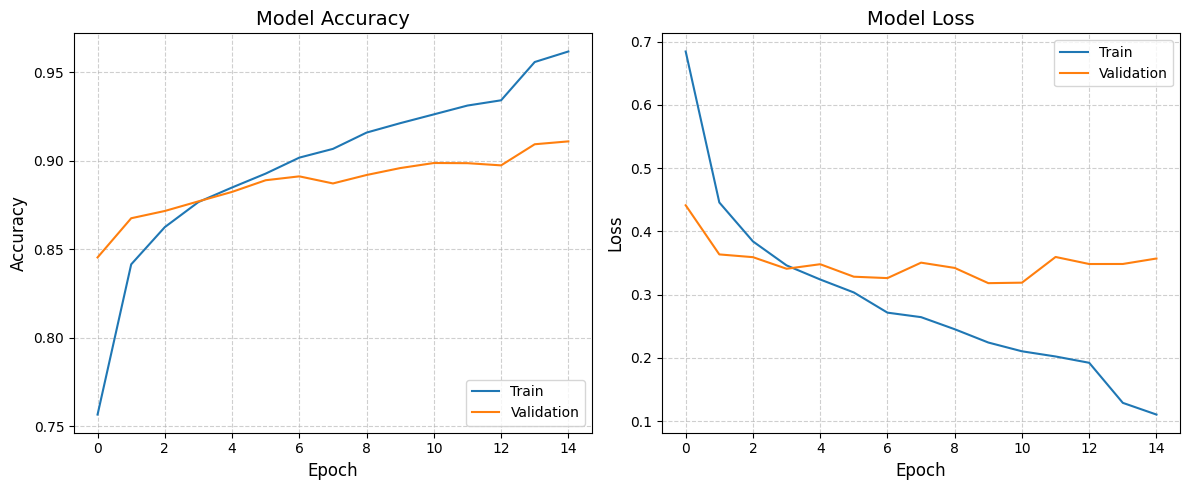

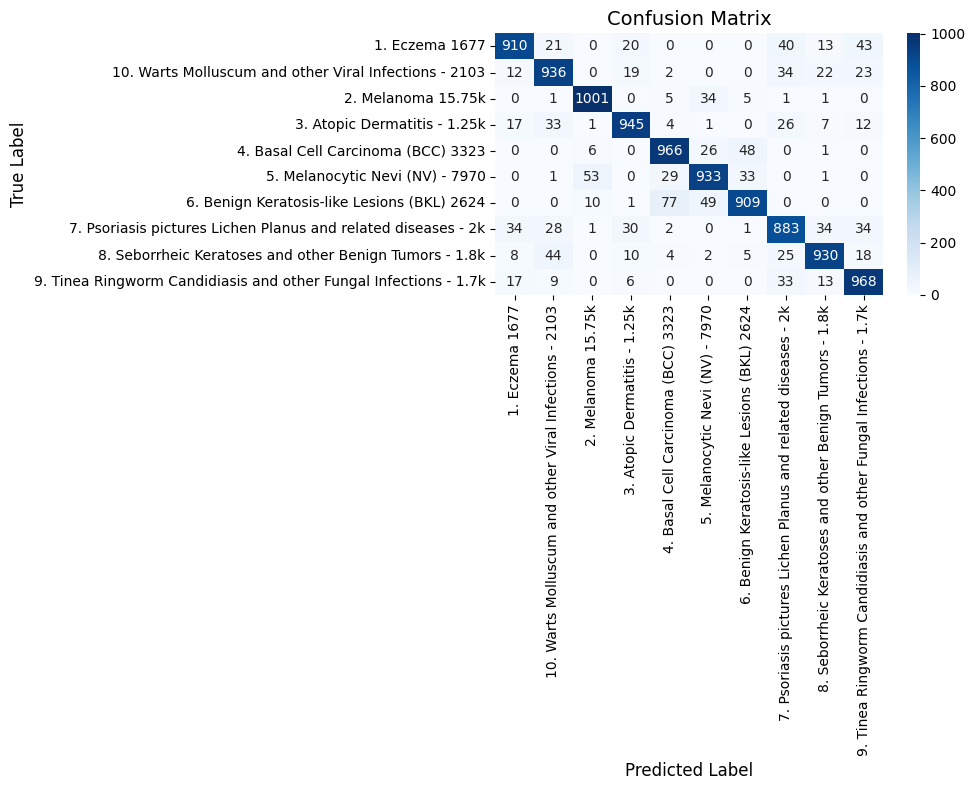

/tmp/ipykernel_31/1531282552.py:107: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


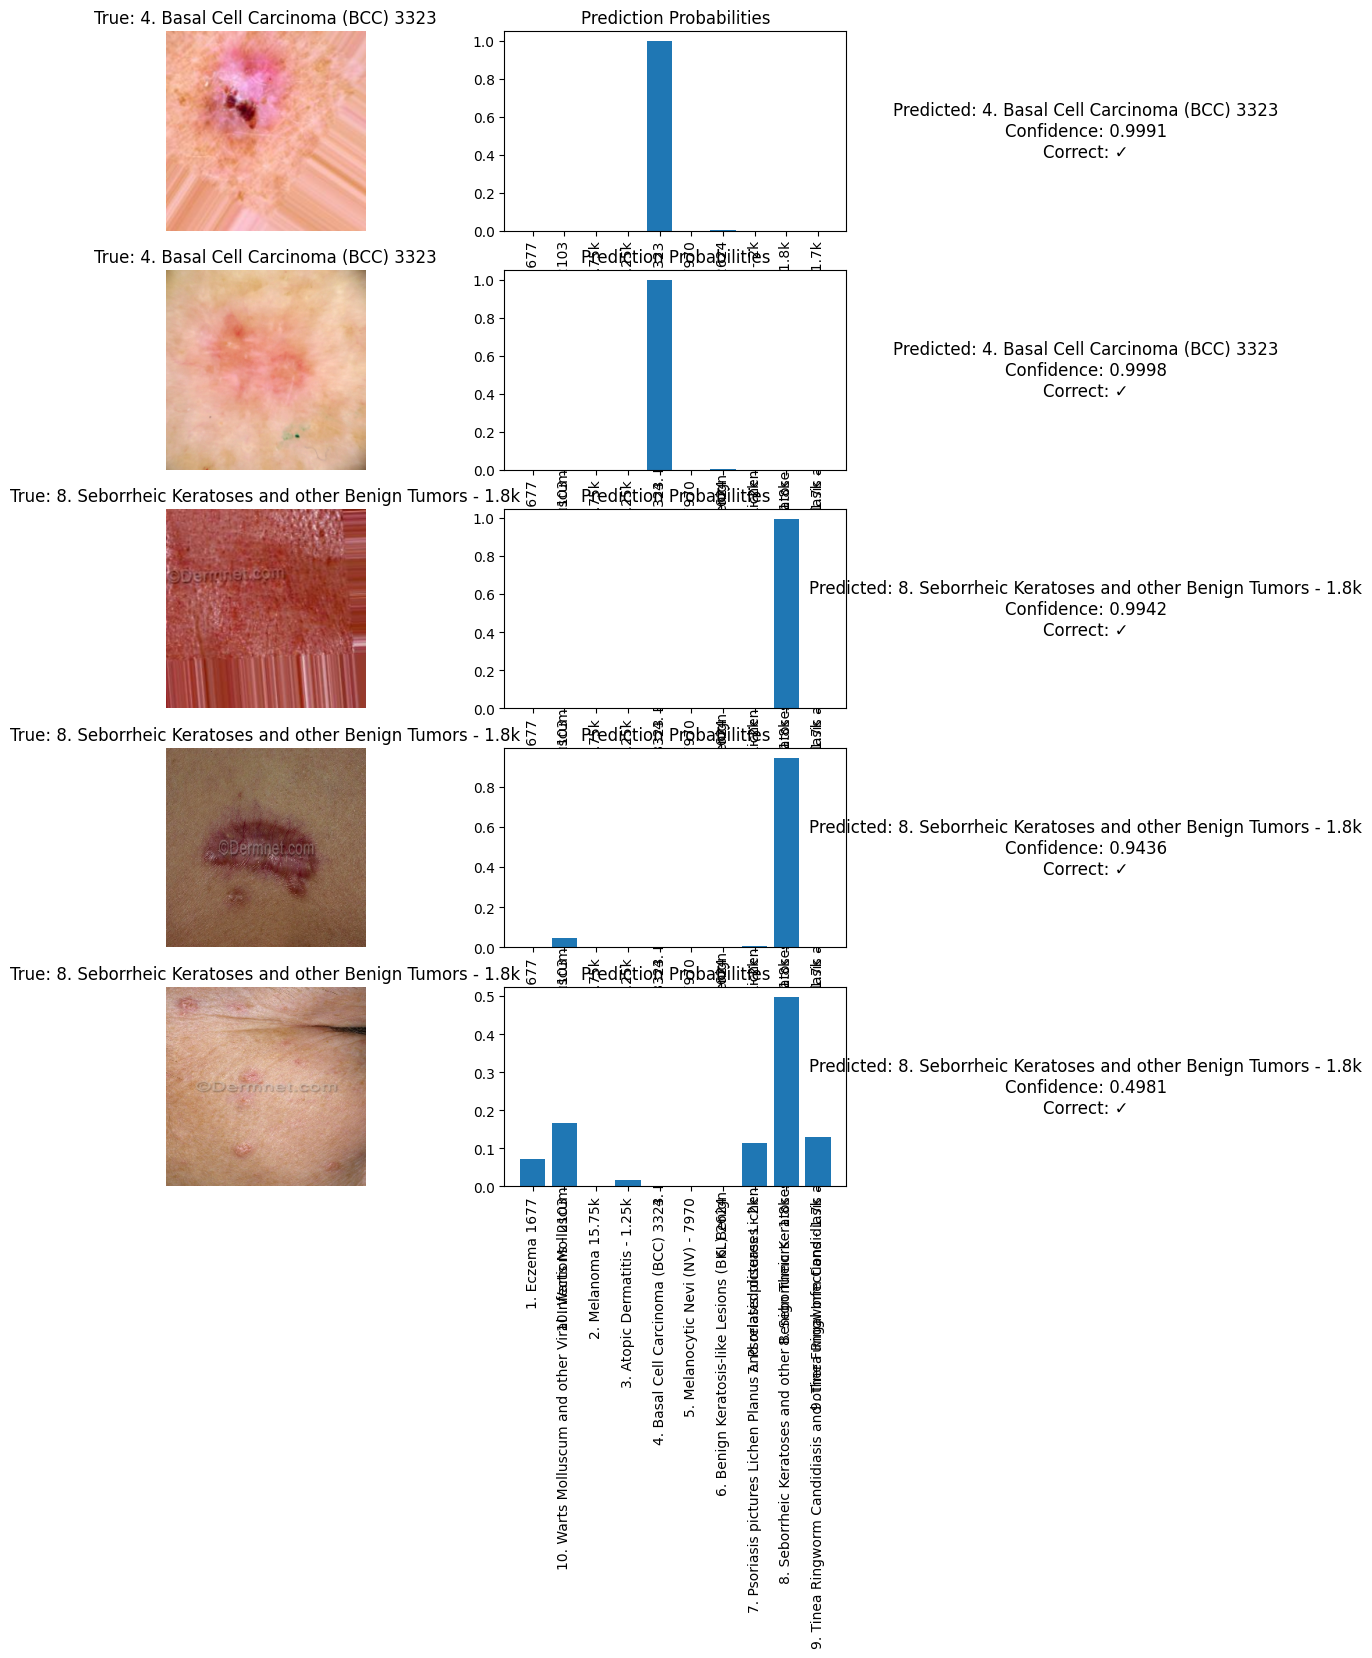

Evaluation and visualization completed. Results saved to /kaggle/working/


In [16]:
import seaborn as sns
print("Evaluating model on validation dataset...")
eval_results = model.evaluate(val_dataset, verbose=1)
print(f"Validation Loss: {eval_results[0]:.4f}")
print(f"Validation Accuracy: {eval_results[1]:.4f}")

# Function to get predictions and true labels from a dataset
def get_predictions(dataset, model):
    y_pred = []
    y_true = []
    
    for images, labels in dataset:
        predictions = model.predict(images, verbose=0)
        pred_classes = np.argmax(predictions, axis=1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(pred_classes)
    
    return np.array(y_true), np.array(y_pred)

# Get predictions
y_true, y_pred = get_predictions(val_dataset, model)

# Create and display classification report
print("Classification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
print(report)

# Save the report to a file
with open('/kaggle/working/classification_report.txt', 'w') as f:
    f.write(report)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# ---------------------- VISUALIZATIONS ----------------------
# 1. Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('/kaggle/working/training_history.png')
plt.show()

# 2. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png')
plt.show()

# 3. Visualize sample predictions
def plot_sample_predictions(dataset, model, class_names, num_samples=5):
    plt.figure(figsize=(15, num_samples*3))
    
    for i, (images, labels) in enumerate(dataset.take(1)):
        predictions = model.predict(images, verbose=0)
        pred_classes = np.argmax(predictions, axis=1)
        
        for j in range(min(num_samples, len(images))):
            plt.subplot(num_samples, 3, j*3+1)
            # Convert from preprocessed image back to display format
            img = images[j].numpy()
            # Simple normalization for display
            img = (img - img.min()) / (img.max() - img.min())
            plt.imshow(img)
            plt.title(f"True: {class_names[labels[j]]}")
            plt.axis('off')
            
            plt.subplot(num_samples, 3, j*3+2)
            plt.bar(range(len(class_names)), predictions[j])
            plt.xticks(range(len(class_names)), class_names, rotation=90)
            plt.title("Prediction Probabilities")
            
            plt.subplot(num_samples, 3, j*3+3)
            plt.text(0.5, 0.5, 
                    f"Predicted: {class_names[pred_classes[j]]}\n" +
                    f"Confidence: {predictions[j][pred_classes[j]]:.4f}\n" +
                    f"Correct: {'✓' if pred_classes[j] == labels[j] else '✗'}", 
                    ha='center', va='center', fontsize=12)
            plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/sample_predictions.png')
    plt.show()

# Visualize a few sample predictions
plot_sample_predictions(val_dataset, model, class_names)

# 4. Plot learning rate changes (if ReduceLROnPlateau was triggered)
if 'lr' in history.history:
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['lr'])
    plt.title('Learning Rate Schedule', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Learning Rate', fontsize=12)
    plt.yscale('log')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig('/kaggle/working/learning_rate.png')
    plt.show()

# 5. Create a model performance summary file
with open('/kaggle/working/model_performance_summary.txt', 'w') as f:
    f.write(f"Model: EfficientNetB3 Transfer Learning\n")
    f.write(f"Validation Accuracy: {eval_results[1]:.4f}\n")
    f.write(f"Validation Loss: {eval_results[0]:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)
    f.write("\nConfusion Matrix:\n")
    f.write(str(cm))

print("Evaluation and visualization completed. Results saved to /kaggle/working/")

In [ ]:
# Model Comparison Section
import time
from tensorflow.keras.applications import (
    ResNet50V2, 
    DenseNet121, 
    MobileNetV2, 
    InceptionV3,
    Xception
)

# Define a function to create and train models
def train_and_evaluate_model(model_name, base_model_fn, epochs=30):
    print(f"\n\n{'='*50}")
    print(f"Training {model_name}...")
    print(f"{'='*50}")
    
    # Record start time
    start_time = time.time()
    
    # Create base model
    base_model = base_model_fn(
        input_shape=(256, 256, 3),
        include_top=False,
        weights='imagenet',
        pooling='max'
    )
    
    # Freeze base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Build full model
    inputs = base_model.input
    x = BatchNormalization()(base_model.output)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)  # Add dropout for regularization
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Flatten()(x)
    outputs = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    lr_reduction = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )
    
    # Train model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[early_stopping, lr_reduction]
    )
    
    # Calculate training time
    training_time = time.time() - start_time
    
    # Evaluate model
    eval_results = model.evaluate(val_dataset, verbose=1)
    val_loss, val_acc = eval_results
    
    # Get predictions for confusion matrix
    y_true, y_pred = get_predictions(val_dataset, model)
    
    # Create visualizations
    create_model_visualizations(model, history, y_true, y_pred, class_names, model_name)
    
    # Save model
    model_path = f'/kaggle/working/{model_name.lower().replace(" ", "_")}_model.h5'
    model.save(model_path)
    
    return {
        'name': model_name,
        'val_accuracy': val_acc,
        'val_loss': val_loss,
        'training_time': training_time,
        'history': history.history,
        'model_path': model_path
    }

# Function to create visualizations for model comparison
def create_model_visualizations(model, history, y_true, y_pred, class_names, model_name):
    # Format name for filenames
    name_for_file = model_name.lower().replace(" ", "_")
    
    # 1. Plot training history
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} - Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} - Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/{name_for_file}_history.png')
    plt.show()
    
    # 2. Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/{name_for_file}_confusion_matrix.png')
    plt.show()
    
    # Save classification report
    report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
    with open(f'/kaggle/working/{name_for_file}_classification_report.txt', 'w') as f:
        f.write(report)

# Define models to compare
models_to_compare = [
    ('ResNet50V2', ResNet50V2),
    ('DenseNet121', DenseNet121),
    ('MobileNetV2', MobileNetV2),
    ('Xception', Xception),
    ('InceptionV3', InceptionV3)
]

# Train and evaluate each model
results = []
for model_name, model_fn in models_to_compare:
    result = train_and_evaluate_model(model_name, model_fn, epochs=30)
    results.append(result)

# Add your existing EfficientNetB3 results for comparison
efficientnet_result = {
    'name': 'EfficientNetB3',
    'val_accuracy': eval_results[1],
    'val_loss': eval_results[0],
    'training_time': 0,  # You don't have this value for the original model
    'model_path': model_save_path
}
results.append(efficientnet_result)

# Compare performance in a table
comparison_df = pd.DataFrame([
    {
        'Model': result['name'],
        'Validation Accuracy': f"{result['val_accuracy']:.4f}",
        'Validation Loss': f"{result['val_loss']:.4f}",
        'Training Time (s)': f"{result['training_time']:.2f}" if 'training_time' in result else 'N/A'
    }
    for result in results
])

# Sort by validation accuracy (descending)
comparison_df = comparison_df.sort_values('Validation Accuracy', ascending=False)

# Display and save comparison table
print("\n\nModel Comparison Results:")
print(comparison_df)
comparison_df.to_csv('/kaggle/working/model_comparison.csv', index=False)

# Create comparison plots
plt.figure(figsize=(15, 8))

# Plot validation accuracy comparison
plt.subplot(1, 2, 1)
model_names = [result['name'] for result in results]
accuracies = [result['val_accuracy'] for result in results]
colors = plt.cm.viridis(np.linspace(0, 0.9, len(results)))

bars = plt.bar(model_names, accuracies, color=colors)
plt.title('Validation Accuracy by Model', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Validation Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0.7, 1.0)  # Adjust as needed based on your results

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f'{height:.4f}',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

plt.grid(axis='y', linestyle='--', alpha=0.3)

# Plot validation loss comparison
plt.subplot(1, 2, 2)
losses = [result['val_loss'] for result in results]

bars = plt.bar(model_names, losses, color=colors)
plt.title('Validation Loss by Model', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Validation Loss', fontsize=14)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01,
        f'{height:.4f}',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig('/kaggle/working/model_comparison_chart.png')
plt.show()

# Create a summary report with findings and recommendations
with open('/kaggle/working/model_comparison_summary.txt', 'w') as f:
    f.write("# Skin Disease Classification Model Comparison\n\n")
    f.write(f"Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("## Models Evaluated\n")
    for result in results:
        f.write(f"- {result['name']}\n")
    
    f.write("\n## Performance Summary\n")
    f.write(comparison_df.to_string(index=False))
    
    # Get the best model
    best_model = comparison_df.iloc[0]['Model']
    best_accuracy = comparison_df.iloc[0]['Validation Accuracy']
    
    f.write(f"\n\n## Key Findings\n")
    f.write(f"- The best performing model is {best_model} with a validation accuracy of {best_accuracy}\n")
    f.write("- The comparison highlights trade-offs between accuracy and model complexity\n")
    
    f.write("\n## Recommendations\n")
    f.write("- For deployment where accuracy is the primary concern, use the top-performing model\n")
    f.write("- For deployment on mobile/edge devices, consider MobileNetV2 for its efficiency\n")
    f.write("- Consider ensemble methods combining the top 2-3 models for potentially higher accuracy\n")
    
    f.write("\n## Next Steps\n")
    f.write("1. Fine-tune the top-performing model with unfrozen layers\n")
    f.write("2. Test on external validation data to ensure generalizability\n")
    f.write("3. Implement model explainability techniques to understand predictions\n")
    f.write("4. Optimize model size and inference speed for deployment\n")

print("Model comparison completed and summary saved to '/kaggle/working/model_comparison_summary.txt'")



Training ResNet50V2...
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 191s 113ms/step - accuracy: 0.4985 - loss: 1.3954 - val_accuracy: 0.7423 - val_loss: 0.7362 - learning_rate: 0.0010
Epoch 2/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 159s 104ms/step - accuracy: 0.7364 - loss: 0.7370 - val_accuracy: 0.8006 - val_loss: 0.6061 - learning_rate: 0.0010
Epoch 3/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 158s 104ms/step - accuracy: 0.7853 - loss: 0.5951 - val_accuracy: 0.8149 - val_loss: 0.5771 - learning_rate: 0.0010
Epoch 4/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 158s 103ms/step - accuracy: 0.8101 - loss: 0.5268 - val_accuracy: 0.8206 - val_loss: 0.5468 - learning_rate: 0.0010
Epoch 5/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 158s 103ms/step - accuracy: 0.8224 - loss: 0.4927 - val_accuracy: 0.8242 - val_loss: 0.5358 - learning_rate: 0.0010
Epoch 6/30
 118/1528 ━━━━━━━━━━━━━━━━━━━━ 2:01 86ms/step - accuracy: 0.8311 - loss: 0.4827

In [ ]:
from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load ResNet50 base model
resnet_base = ResNet50(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze layers
for layer in resnet_base.layers:
    layer.trainable = False

# Add custom head
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

# Build and compile the model
resnet_model = Model(inputs=resnet_base.input, outputs=outputs)
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train model
resnet_history = resnet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop, lr_reduce]
)

# Save model
resnet_model.save('/kaggle/working/resnet_model.h5')
print('ResNet50 model saved.')